In [1]:
import manga109api

In [2]:
manga109_root = "../datasets/Manga109/Manga109_released_2021_12_30"
dataset = manga109api.Parser(manga109_root)

In [3]:
dataset.get_annotation("Arisa")['page'][4]['text']

[{'@id': '000060b3',
  '@xmin': 146,
  '@ymin': 74,
  '@xmax': 196,
  '@ymax': 128,
  '#text': '先生に怒られ',
  'type': 'text'},
 {'@id': '000060b4',
  '@xmin': 694,
  '@ymin': 323,
  '@xmax': 736,
  '@ymax': 530,
  '#text': 'きゃあああ',
  'type': 'text'},
 {'@id': '000060b5',
  '@xmin': 1516,
  '@ymin': 775,
  '@xmax': 1614,
  '@ymax': 906,
  '#text': '教えてもらった引っ越し先にはあいつの家はなくて･･･',
  'type': 'text'},
 {'@id': '000060b7',
  '@xmin': 450,
  '@ymin': 72,
  '@xmax': 541,
  '@ymax': 215,
  '#text': 'どどうしよう･･･初日から ぐすっ遅刻なんて･･･',
  'type': 'text'},
 {'@id': '000060b8',
  '@xmin': 320,
  '@ymin': 914,
  '@xmax': 378,
  '@ymax': 1006,
  '#text': 'ぐえ',
  'type': 'text'},
 {'@id': '000060b9',
  '@xmin': 1598,
  '@ymin': 539,
  '@xmax': 1619,
  '@ymax': 631,
  '#text': 'あいつ･･･',
  'type': 'text'},
 {'@id': '000060bf',
  '@xmin': 1188,
  '@ymin': 840,
  '@xmax': 1238,
  '@ymax': 937,
  '#text': 'あれっきり消息不明･･･',
  'type': 'text'},
 {'@id': '000060c3',
  '@xmin': 914,
  '@ymin': 555,
  '@xmax': 1002,
  '@ymax':

In [4]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

%matplotlib inline

# Directory to save logs and trained model
MODEL_DIR = "model"
#
# # Local path to trained weights file
# COCO_MODEL_PATH = "../model-weights/mask_rcnn_coco.h5"
# # Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
import cv2
class MangaDataset(utils.Dataset):
    """Loads the manga109 dataset. The labels consist of "frame" and "text".
    """

    def load_manga(self, is_train = True):
        """Loads the images.
        """
        # Add classes
        self.add_class("manga", 1, "frame")
        self.add_class("manga", 2, "text")

        count = -1
        # add images
        for book in dataset.books:
            for page in dataset.get_annotation(book)["page"]:

                # train test split
                count += 1
                if count % 5 == 0 and is_train: continue
                if count % 5 != 0 and (not is_train): continue

                attr = {"book": book, "page": page["@index"]}

                self.add_image("manga", image_id=count, path=manga109_root + "/images/" + book + "/" + str(page["@index"]).zfill(3) + ".jpg", book=book, page=page["@index"])


    def image_reference(self, image_id):
        """Return the manga data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "manga":
            return info["manga"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        book = info["book"]
        page = dataset.get_annotation(book)["page"][info["page"]]
        class_ids = []
        masks = []
        width = page["@width"]
        height = page["@height"]
        for frame in page["frame"]:
            mask = np.zeros((height, width), dtype="uint8")
            mask[frame["@ymin"] : frame["@ymax"], frame["@xmin"] : frame["@xmax"]] = 1
            masks.append(mask)
            class_ids.append(self.class_names.index("frame"))
        for text in page["text"]:
            mask = np.zeros((height, width), dtype="uint8")
            mask[text["@ymin"] : text["@ymax"], text["@xmin"] : text["@xmax"]] = 2
            masks.append(mask)
            class_ids.append(self.class_names.index("text"))
        if class_ids:
            masks_arr = np.dstack(masks)
        else:
            masks_arr = np.zeros((height, width, 1))
            class_ids.append(0)
        return masks_arr, np.array(class_ids).astype(np.int32)

In [7]:
train_set = MangaDataset()
train_set.load_manga(is_train=True)
train_set.prepare()

test_set = MangaDataset()
test_set.load_manga(is_train=False)
test_set.prepare()

In [8]:
class MangaConfig(Config):
    """Configuration for training on the manga109 dataset.
    Derives from the base Config class and overrides values specific
    to the manga109 dataset.
    """
    # Give the configuration a recognizable name
    NAME = "manga"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 2  # background + 2 classes (frame + text)

    STEPS_PER_EPOCH = len(train_set.image_ids)

    TRAIN_ROIS_PER_IMAGE = 128

    IMAGES_PER_GPU = 1

    GPU_COUNT = 1


config = MangaConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [9]:
class InferenceConfig(MangaConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead
Loading weights from  model\manga20220213T2059\mask_rcnn_manga_0002.h5
Re-starting from epoch 2


In [10]:
model.keras_model.summary()

Model: "mask_rcnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_image[0][0]']            
                                3)                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, None, None,   9472        ['zero_padding2d[0][0]']         
                                64)                                                       

original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1654.00000  float64
gt_class_id              shape: (12,)                 min:    1.00000  max:    2.00000  int32
gt_bbox                  shape: (12, 4)               min:    1.00000  max: 1023.00000  int32
gt_mask                  shape: (1024, 1024, 12)      min:    0.00000  max:    2.00000  uint8


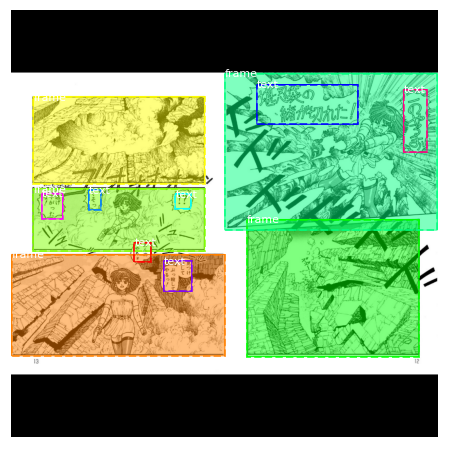

In [9]:
import random
# Test on a random image
image_id = 1
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(test_set, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            test_set.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (15,)                 min:    0.00000  max: 1654.00000  float64
class_id                 shape: (10,)                 min:    1.00000  max:    2.00000  int32
bbox                     shape: (10, 4)               min:    0.00000  max: 1024.00000  int32
masks                    shape: (1024, 1024, 10)      min:    0.00000  max:    1.00000  bool
scores                   shape: (10,)                 min:    0.92151  max:    0.99787  float32


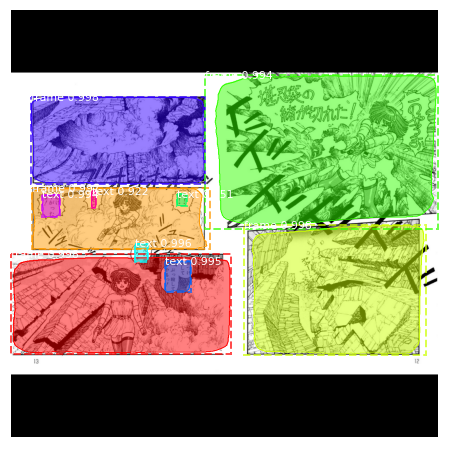

In [10]:
results = model.detect([original_image], verbose=1)

r = results[0]

log("original_image", original_image)
log("image_meta", image_meta)
log("class_id", r["class_ids"])
log("bbox", r["rois"])
log("masks", r["masks"])
log("scores", r["scores"])

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            test_set.class_names, r['scores'], ax=get_ax())

In [11]:
# # Compute VOC-Style mAP @ IoU=0.5
# # Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(train_set.image_ids, 10)
# APs = []
# for image_id in image_ids:
#     # Load image and ground truth data
#     image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#         modellib.load_image_gt(train_set, inference_config,
#                                image_id)
#     molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
#     # Run object detection
#     results = model.detect([image], verbose=0)
#     r = results[0]
#     # Compute AP
#     AP, precisions, recalls, overlaps =\
#         utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
#                          r["rois"], r["class_ids"], r["scores"], r['masks'])
#     APs.append(AP)
#
# print("mAP: ", np.mean(APs))

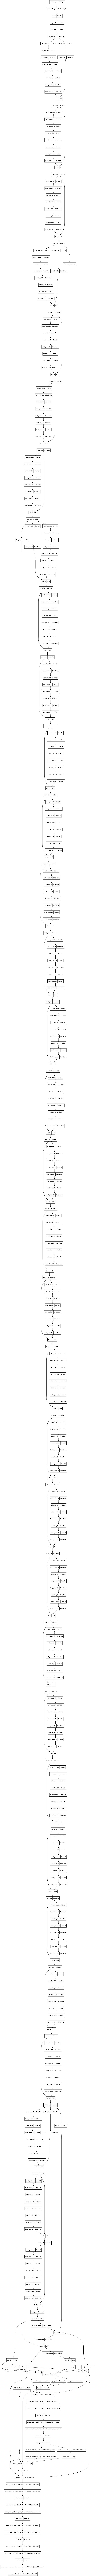

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(model.keras_model)